The dataset contains 2 folders - Infected - Uninfected. This is a classification problem with the target variable containing 2 classes namely Infected and Uninfected. The inputs are the images of cells affected with the virus causing malaria and of uninfected cells. Our neural network is supposed to train on these image data and predict if a cell is infected or not based on future image given. This will help in easier diagnosis and help doctors in a great way. 

We can also play with the threshold probability for classification of target classes according to our needs. Instead classifying based on 50 percent threshold, we can increase threshold based on the importance of not misclassifying an infected image as not infected. Here, false negative has a greater impact than false positives.

The given dataset contains a total of 27,558 images. Already scaled(normalized) dataset between 0 to 1 not from 0 to 255.

Acknowledgement: This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/

In [1]:
import os #For working with data directories where images are located
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread #To read in image files

In [2]:
data_dir = r"C:\Users\RISHI MUKUNTHAN\Desktop\Data Science\Projects\Malarial_Cells_Classification\cell_images"

In [3]:
#List sub-folders in the directory
os.listdir(data_dir)

['test', 'train']

In [4]:
train_path = data_dir + '\\train\\'
test_path = data_dir + '\\test\\'

In [5]:
#Classes or subfolders under training data
os.listdir(train_path)

['parasitized', 'uninfected']

In [6]:
#List the first image file name under parasitized class
os.listdir(train_path+'parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [7]:
#List the first image file name under uninfected class
os.listdir(train_path+'uninfected')[0]

'C100P61ThinF_IMG_20150918_144104_cell_128.png'

In [8]:
#Save complete file path to an image file and use imread and imshow function to display image.
para_cell = train_path+'parasitized\\'+'C100P61ThinF_IMG_20150918_144104_cell_162.png'
uninfected_cell = train_path+'uninfected\\'+'C100P61ThinF_IMG_20150918_144104_cell_128.png'

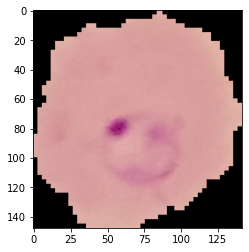

In [9]:
plt.imshow(imread(para_cell))

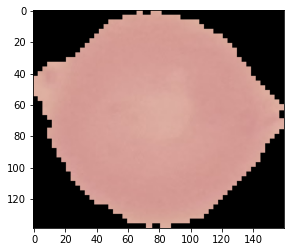

In [10]:
plt.imshow(imread(uninfected_cell))

In [11]:
#No of images. Balanced dataset.
len(os.listdir(train_path+'parasitized'))

12479

In [12]:
len(os.listdir(train_path+'uninfected'))

12479

In [13]:
#Check dimensions of our images
dim1 = []
dim2 = []

for image_filename in os.listdir(train_path+'uninfected'):
    
    img = imread(train_path+'uninfected\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

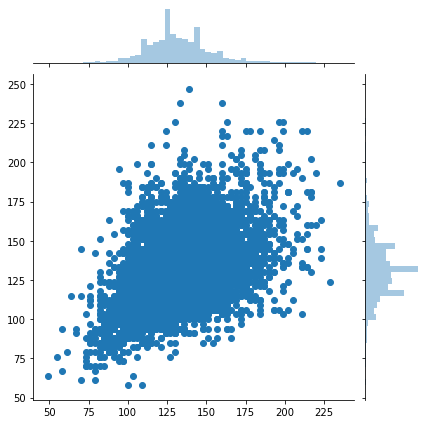

In [14]:
sns.jointplot(dim1,dim2)

In [15]:
#Take mean of our dim1 and dim2 and resize all images to a fixed constant dimension/shape
np.mean(dim1)

131.64820899110507

In [16]:
np.mean(dim2)

131.4041990544114

In [17]:
image_shape = (130,130,3)

# ImageDataGenerator

ImageDataGenerator - used to do manipulations to given images. MNIST was 28*28 and CIFAR10 was 32*32*3. 
130*130*3 is huge compared to that. So we cannot feed all images at once. Instead we need to feed in batches.

Doing transformations like rotation, scaling our images should be handled by our model for it to be robust to handle
different images.

For a simple MNIST dataset we needed 60000 images. For complex image classification, we need a ton of training images.
But it is not practical. Doing transformation and feeding different transformations of the same image helps us handle this
data scarcity problem.

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
#Rotate randomly by maximum 20 degrees, stretch by max 10%, rescale by *1/255. Shear/cut away part of image by 10%
# Fill stretched space by nearest pixel values
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range = 0.1,
                               height_shift_range=0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')

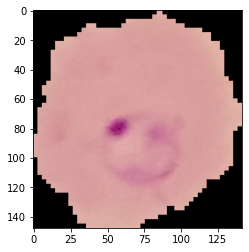

In [20]:
plt.imshow(imread(para_cell))

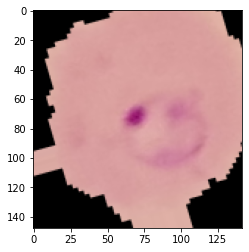

In [21]:
plt.imshow(image_gen.random_transform(imread(para_cell)))

We had less than 30000 images but now by doing random transformations we can augment our dataset by doubling our input data.
CNNs typically require thousands of images to perform well.

To Use flow from directory, the images should be organized in sub directories for each class

In [22]:
#Flow batches from directory
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [23]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


## Creating our Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten

In [25]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [28]:
#Need larger batch size need better hardware
#Smaller the batch size longer the training time
batch_size = 16

In [29]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2],
                                                color_mode='rgb', batch_size = batch_size,
                                                class_mode = 'binary')

Found 24958 images belonging to 2 classes.


In [30]:
test_image_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2],
                                               color_mode='rgb', batch_size = batch_size,
                                               class_mode = 'binary', shuffle = False)

Found 2600 images belonging to 2 classes.


In [31]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
results = model.fit_generator(train_image_gen, epochs=20,
                              validation_data=test_image_gen,
                              callbacks=[early_stop])

In [ ]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')

In [33]:
from tensorflow import keras
model = keras.models.load_model('malaria_detector.h5')

# Evaluating the Model

In [ ]:
losses = pd.DataFrame(model.history.history)

In [ ]:
losses[['loss','val_loss']].plot()

In [35]:
model.metrics_names

['loss', 'accuracy']

In [36]:
model.evaluate_generator(test_image_gen)

[1.8651531682424018, 0.87846154]

In [37]:
from tensorflow.keras.preprocessing import image
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

In [38]:
pred_probabilities

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [39]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [40]:
#Determines the precision , recall values. Depending on which is important for our use case
predictions = pred_probabilities > 0.5

In [41]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1300
           1       0.97      0.75      0.85      1300

    accuracy                           0.86      2600
   macro avg       0.88      0.86      0.86      2600
weighted avg       0.88      0.86      0.86      2600



In [42]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1270,   30],
       [ 321,  979]], dtype=int64)

# Predicting on an Image

In [43]:
#Alternative to matplotlib
my_image = image.load_img(para_cell,target_size=image_shape)

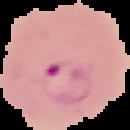

In [44]:
my_image

In [45]:
type(my_image)

PIL.Image.Image

In [46]:
my_image = image.img_to_array(my_image)

In [47]:
type(my_image)

numpy.ndarray

In [48]:
my_image = np.expand_dims(my_image, axis=0)

In [49]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [50]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [51]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}